# Reddit Stream

### Step 00: Import libraries

In [5]:
from utils import reddit_utils, plot_utils, sentiment_utils

In [2]:
import praw
import nltk

### Step 01: Reddit

In [14]:
reddit = praw.Reddit(
    client_id=input("Client ID: "),
    client_secret=input("Client Secret: "),
    username=input("Username: "),
    password=input("Password: "),
    user_agent=input("User agent: ")
)

### Step 02: Reading subreddit

In [4]:
subreddit = "AskReddit"
duration_stream = 60*60*2 # seconds

In [ ]:
reddit_df = reddit_utils.stream_comments_to_dataframe(reddit, subreddit, duration_stream)

Start streaming from r/AskReddit...
Stop streaming!


### Step 03: Sentiment Intensity Analyzer

In [ ]:
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

In [9]:
reddit_df = sentiment_utils.apply_sentiment(reddit_df, "text")

### Step 04: Number of comments

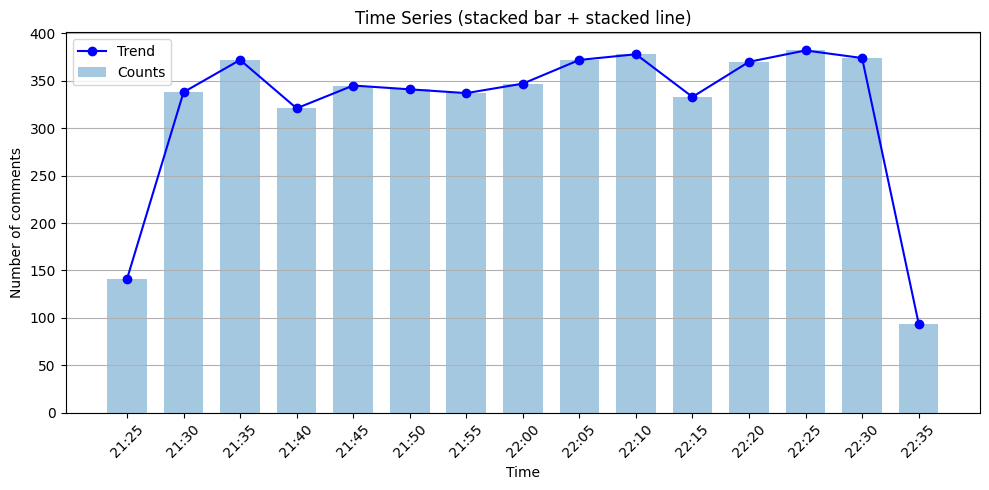

In [16]:
plot_utils.plot_time_series(reddit_df["datetime"], interval_minutes=5, figsize=(10,5), ylabel="Number of comments")

### Step 05: Sentiment plot

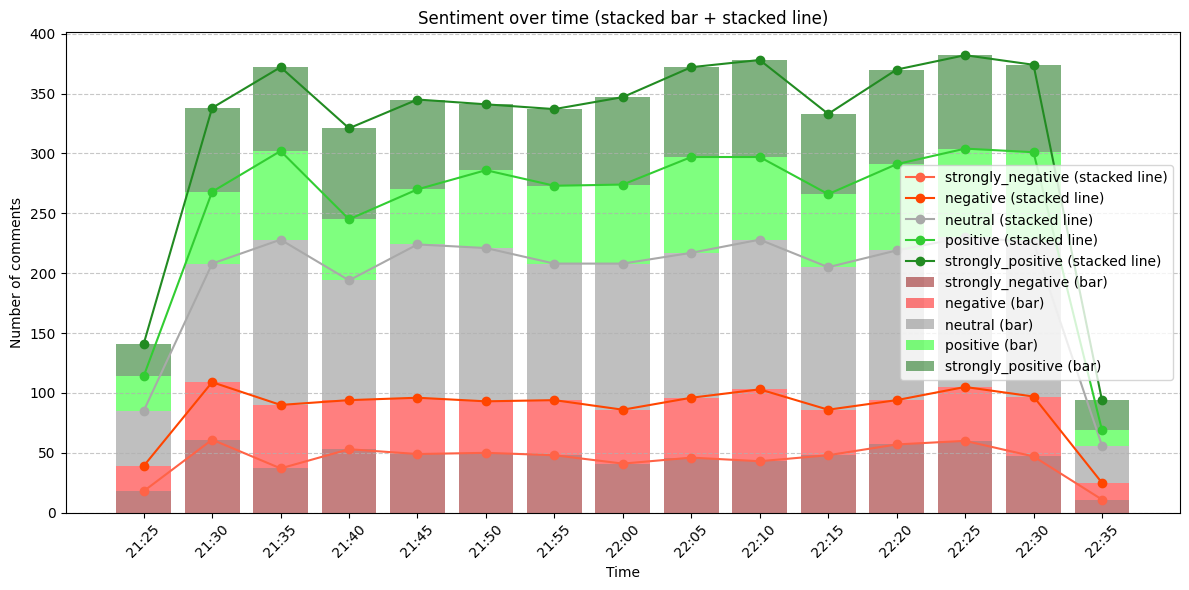

In [17]:
plot_utils.plot_sentiment_over_time(reddit_df, interval_minutes=5, figsize=(12,6), ylabel="Number of comments", has_legend=True)

### Step 06: Wordcloud

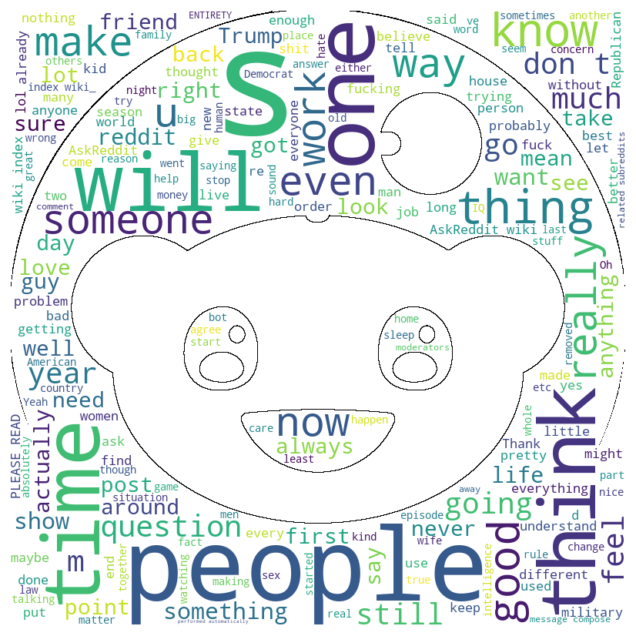

In [8]:
full_text = " ".join(reddit_df["text"])
url_pic = "https://redditinc.com/hs-fs/hubfs/Reddit%20Inc/Content/Brand%20Page/Reddit_Logo.png?width=800&height=800&name=Reddit_Logo.png"
plot_utils.plot_wordcloud(url_pic, full_text)